In [1]:
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import statsmodels.formula.api as smf
import xgboost as xgb
from yellowbrick.regressor import CooksDistance
from yellowbrick.datasets import load_concrete
from sklearn.metrics import explained_variance_score
from sklearn.svm import SVR

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Loading Data

In [2]:
data=pd.read_excel('D:/Data Set.xlsx')

In [3]:
data.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,...,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,...,1,0,1,0,1,0,0,0,1,0


# Creating the Y variable


In [4]:
data['totalspend']=data['cardspent']+data['card2spent']

In [5]:
data.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,totalspend
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,1,1,0,0,0,1,0,149.46
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,0,0,0,77.54
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,0,0,0,0,0,1,0,0,0,359.97
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,...,0,1,1,1,0,1,1,0,0,359.41
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,...,0,1,0,1,0,0,0,1,0,507.83


In [ ]:
# pandas profiling
pandas_profiling.ProfileReport(data)

In [6]:
# dropping less important and high missing values variables based on pandas profiling
data.drop(['custid','cardspent','card2spent','birthmonth','lncardmon','lncardten','lnequipmon','lnequipten','lntollmon','lntollten','lnwiremon','lnwireten'],axis=1,inplace=True)


In [7]:
# Creating categorical variables
for x in ['region','townsize','gender','agecat','edcat','jobcat','union','employ','empcat','retire',
          'inccat','default','jobsat','marital','spousedcat','homeown','hometype','address','addresscat','cars','carown',
          'cartype','carcatvalue','carbought','carbuy','commute','commutecat','commutecar',
          'commutemotorcycle','commutecarpool','commutebus','commuterail','commutepublic','commutebike','commutewalk',
         'commutenonmotor','telecommute','reason','polview','polparty','polcontrib','vote','card','cardtype','cardbenefit',
         'cardfee','cardtenure','cardtenurecat','card2','card2type','card2benefit','card2fee','card2tenure','card2tenurecat',
         'active','bfast','churn','tollfree','equip','callcard','wireless','multline','voice','pager','internet','callid',
         'callwait','forward','confer','ebill','owntv','ownvcr','owndvd','owncd','ownpda','ownpc','ownipod','owngame','ownfax',
        'news','response_01','response_02','response_03']:
    data[x]=data[x].astype('object')

In [8]:
# dropping these as they have cat>20
data.drop(['cardtenure','card2tenure'],axis=1,inplace=True)

In [9]:
# Finding Numerical variables in dataframe
numeric_var_names = [key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]

# Find Categorical variable in Data frame
cat_var_names = [key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['object']]

#Print the diff lists
print( numeric_var_names)
print(cat_var_names)

['age', 'ed', 'income', 'lninc', 'debtinc', 'creddebt', 'lncreddebt', 'othdebt', 'lnothdebt', 'spoused', 'reside', 'pets', 'pets_cats', 'pets_dogs', 'pets_birds', 'pets_reptiles', 'pets_small', 'pets_saltfish', 'pets_freshfish', 'carvalue', 'commutetime', 'tenure', 'longmon', 'lnlongmon', 'longten', 'lnlongten', 'tollmon', 'tollten', 'equipmon', 'equipten', 'cardmon', 'cardten', 'wiremon', 'wireten', 'hourstv', 'totalspend']
['region', 'townsize', 'gender', 'agecat', 'edcat', 'jobcat', 'union', 'employ', 'empcat', 'retire', 'inccat', 'default', 'jobsat', 'marital', 'spousedcat', 'homeown', 'hometype', 'address', 'addresscat', 'cars', 'carown', 'cartype', 'carcatvalue', 'carbought', 'carbuy', 'commute', 'commutecat', 'commutecar', 'commutemotorcycle', 'commutecarpool', 'commutebus', 'commuterail', 'commutepublic', 'commutebike', 'commutewalk', 'commutenonmotor', 'telecommute', 'reason', 'polview', 'polparty', 'polcontrib', 'vote', 'card', 'cardtype', 'cardbenefit', 'cardfee', 'cardtenur

In [10]:
#converting into data frame
data_num=data[numeric_var_names]
data_cat=data[cat_var_names]

In [11]:
#Data Summary
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=data_num.apply(lambda x: var_summary(x)).T

In [12]:
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,5000.0,0.0,2.351280e+05,47.025600,47.000000,17.770338,3.157849e+02,18.000000,18.000000,20.000000,23.000000,31.000000,47.000000,62.000000,72.000000,76.000000,79.000000,79.000000
ed,5000.0,0.0,7.271500e+04,14.543000,14.000000,3.281083,1.076550e+01,6.000000,8.000000,9.000000,10.000000,12.000000,14.000000,17.000000,19.000000,20.000000,21.000000,23.000000
income,5000.0,0.0,2.737980e+05,54.759600,38.000000,55.377511,3.066669e+03,9.000000,9.000000,13.000000,16.000000,24.000000,38.000000,67.000000,109.100000,147.000000,272.010000,1073.000000
lninc,5000.0,0.0,1.849955e+04,3.699909,3.637586,0.747072,5.581164e-01,2.197225,2.197225,2.564949,2.772589,3.178054,3.637586,4.204693,4.692261,4.990433,5.605839,6.978214
debtinc,5000.0,0.0,4.977080e+04,9.954160,8.800000,6.399783,4.095723e+01,0.000000,0.700000,1.900000,2.800000,5.100000,8.800000,13.600000,18.600000,22.200000,29.200000,43.100000
creddebt,5000.0,0.0,9.286628e+03,1.857326,0.926437,3.415732,1.166722e+01,0.000000,0.033160,0.101088,0.175682,0.385520,0.926437,2.063820,4.299470,6.373010,14.280358,109.072596
lncreddebt,4999.0,1.0,-6.521372e+02,-0.130454,-0.076106,1.273058,1.620678e+00,-6.597334,-3.401690,-2.291604,-1.737842,-0.952685,-0.076106,0.724665,1.458625,1.852297,2.658910,4.692014
othdebt,5000.0,0.0,1.827230e+04,3.654460,2.098540,5.395172,2.910788e+01,0.000000,0.114299,0.287692,0.457997,0.980301,2.098540,4.314780,8.062046,11.815981,24.064260,141.459150
lnothdebt,4999.0,1.0,3.483879e+03,0.696915,0.741537,1.128578,1.273689e+00,-4.092107,-2.168241,-1.243483,-0.780312,-0.018987,0.741537,1.462053,2.087178,2.469586,3.180802,4.952011
spoused,5000.0,0.0,3.056400e+04,6.112800,-1.000000,7.743518,5.996207e+01,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,14.000000,16.000000,18.000000,20.000000,24.000000


In [13]:
#Outlier Treatment
def outlier_capping(x):
    x = x.clip(lower=x.quantile(0.01),upper=x.quantile(0.99))
   
    return x

data_num = data_num.apply(lambda x: outlier_capping(x))

In [14]:
#Handling Missings
def Missing_imputation(x):
    x = x.fillna(x.median())
    return x

data_num = data_num.apply(lambda x: Missing_imputation(x))


def Missing_imputation1(x):
    x = x.fillna(x.mode())
    return x

data_cat = data_cat.apply(lambda x: Missing_imputation1(x))


In [15]:
# Creating dummy variables
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname)
    col_dummies.drop(col_dummies.columns[0], axis = 1, inplace = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True)
    return df

In [16]:
for c_feature in cat_var_names:
    data_cat[c_feature]=data_cat[c_feature].astype('category')
    data_cat=create_dummies(data_cat,c_feature)

In [17]:
# concat both num and cat variables
final_data=pd.concat([data_num,data_cat],axis=1)

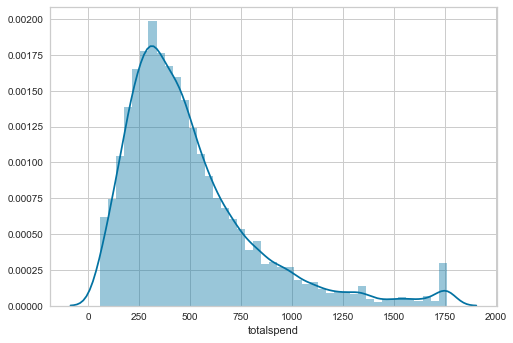

In [18]:
# Checking for normal distribution
sns.distplot(final_data.totalspend)

# Applying tranformation on target variable

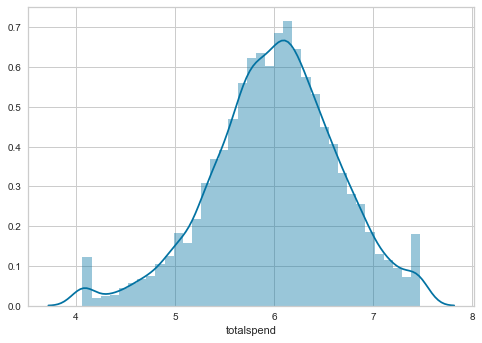

In [19]:
sns.distplot(np.log(final_data.totalspend))

In [20]:
final_data['ln_totalspend']=np.log(final_data.totalspend)

In [21]:
final_data.drop(['totalspend'],axis=1,inplace=True)

In [22]:
feature_columns=final_data.columns.difference(['ln_totalspend'])

# Splitting into train and test for random forest

In [23]:
# split into train and test
train_x,test_x,train_y,test_y=train_test_split(final_data[feature_columns],
                                              final_data['ln_totalspend'],
                                              test_size=0.2,
                                              random_state=12)

# Applying random forest for feature selection

In [27]:
param_grid={'n_estimators':np.arange(10,25)}

In [28]:
# Applying Grid Search
tree=GridSearchCV(RandomForestRegressor(oob_score=False,warm_start=True),param_grid,cv=5,verbose=5)

In [29]:
tree.fit(train_x,train_y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... n_estimators=10, score=0.158, total=   2.0s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] ..................... n_estimators=10, score=0.197, total=   2.0s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV] ..................... n_estimators=10, score=0.164, total=   2.0s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.9s remaining:    0.0s


[CV] ..................... n_estimators=10, score=0.170, total=   2.0s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.9s remaining:    0.0s


[CV] ..................... n_estimators=10, score=0.137, total=   2.0s
[CV] n_estimators=11 .................................................
[CV] ..................... n_estimators=11, score=0.123, total=   2.2s
[CV] n_estimators=11 .................................................
[CV] ..................... n_estimators=11, score=0.223, total=   2.1s
[CV] n_estimators=11 .................................................
[CV] ..................... n_estimators=11, score=0.159, total=   2.1s
[CV] n_estimators=11 .................................................
[CV] ..................... n_estimators=11, score=0.189, total=   2.1s
[CV] n_estimators=11 .................................................
[CV] ..................... n_estimators=11, score=0.160, total=   2.1s
[CV] n_estimators=12 .................................................
[CV] ..................... n_estimators=12, score=0.136, total=   2.3s
[CV] n_estimators=12 .................................................
[CV] .

[CV] ..................... n_estimators=22, score=0.188, total=   4.3s
[CV] n_estimators=22 .................................................
[CV] ..................... n_estimators=22, score=0.219, total=   4.3s
[CV] n_estimators=22 .................................................
[CV] ..................... n_estimators=22, score=0.213, total=   4.1s
[CV] n_estimators=23 .................................................
[CV] ..................... n_estimators=23, score=0.164, total=   4.3s
[CV] n_estimators=23 .................................................
[CV] ..................... n_estimators=23, score=0.229, total=   4.5s
[CV] n_estimators=23 .................................................
[CV] ..................... n_estimators=23, score=0.186, total=   4.3s
[CV] n_estimators=23 .................................................
[CV] ..................... n_estimators=23, score=0.247, total=   4.5s
[CV] n_estimators=23 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  4.2min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(warm_start=True),
             param_grid={'n_estimators': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])},
             verbose=5)

In [31]:
# Best Param
tree.best_params_

{'n_estimators': 22}

In [25]:
# training the model with best Param
fin_clf = RandomForestRegressor(oob_score=True,n_estimators=22)
fin_clf.fit( train_x, train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=22, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [26]:
# getting the top features 
indices = np.argsort(fin_clf.feature_importances_)[::-1]
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(train_x.shape[1]):
  feature_rank.loc[f] = [f+1,
                         train_x.columns[indices[f]],
                         fin_clf.feature_importances_[indices[f]]]

feature_rank.head(50)

,rank,feature,importance
0,1,lninc,0.105444
1,2,income,0.080620
2,3,carvalue,0.026666
3,4,card_3,0.024850
4,5,commutetime,0.022430
5,6,debtinc,0.020981
6,7,card_4,0.020042
7,8,age,0.019837
8,9,hourstv,0.018957
9,10,reason_2,0.018578


In [27]:
x=feature_rank.loc[0:50,['feature']]
x=x['feature'].tolist()
print(x)

['lninc', 'income', 'carvalue', 'card_3', 'commutetime', 'debtinc', 'card_4', 'age', 'hourstv', 'reason_2', 'cardmon', 'card_2', 'creddebt', 'lncreddebt', 'cardten', 'ed', 'othdebt', 'pets', 'lnothdebt', 'tenure', 'tollmon', 'lnlongten', 'card_5', 'longmon', 'tollten', 'card2_3', 'equipmon', 'longten', 'lnlongmon', 'spoused', 'card2_2', 'equipten', 'reside', 'pets_freshfish', 'wiremon', 'pets_cats', 'gender_1', 'pets_dogs', 'vote_1', 'cartype_1', 'townsize_3.0', 'jobsat_4', 'card2type_4', 'commuterail_1', 'commutewalk_1', 'wireten', 'carbought_1', 'forward_1', 'polview_5', 'cardtype_2', 'cardtype_3']


In [30]:
# selecting top 50 feature and selecting the duplicates with log values
rf_features=['lninc', 'card_3', 'carvalue', 'commutetime', 'card_4', 'debtinc', 'hourstv', 'age', 'card_2', 'cardmon', 'reason_2', 'lncreddebt','cardten', 'ed','tenure', 'pets', 'lnothdebt', 'spoused', 'lnlongten', 'card_5', 'tollmon', 'tollten', 'lnlongmon', 'card2_2', 'reside', 'card2_3', 'equipmon', 'pets_freshfish', 'equipten', 'pets_dogs', 'wiremon', 'gender_1', 'pets_cats', 'wireten', 'carbought_1', 'card2_4', 'homeown_1','jobsat_3', 'region_5', 'region_3', 'vote_1', 'polparty_1', 'card2benefit_4', 'active_1', 'commutewalk_1']

In [31]:
# creating dataframe
rf_features.append('ln_totalspend')
df_rf= final_data[rf_features]

df_rf.head(5)

,lninc,card_3,carvalue,commutetime,card_4,debtinc,hourstv,age,card_2,cardmon,...,homeown_1,jobsat_3,region_5,region_3,vote_1,polparty_1,card2benefit_4,active_1,commutewalk_1,ln_totalspend
0,3.433987,1,14.3,22.0,0,11.1,13,20,0,14.25,...,0,0,0,0,1,1,0,0,1,5.007029
1,2.708050,0,6.8,29.0,0,18.6,18,22,1,16.00,...,1,0,1,0,0,1,0,1,0,4.350794
2,3.555348,0,18.8,24.0,0,9.9,21,67,1,23.00,...,1,0,0,1,0,1,0,0,0,5.886021
3,2.995732,0,8.7,38.0,0,5.7,26,23,1,21.00,...,1,0,0,0,0,0,1,1,0,5.884464
4,3.135494,0,10.6,32.0,1,1.7,27,26,0,17.25,...,0,0,0,0,0,0,0,1,1,6.230147


In [23]:
del rf_features[-1]

# Removing multicollinerity by VIF

In [32]:
# Reducing on basis of VIF cutoff of 5
rf_features=['lninc', 'card_3', 'carvalue', 'commutetime', 'card_4', 'debtinc', 'hourstv', 'age', 'card_2', 'cardmon', 'reason_2', 'lncreddebt', 'ed','tenure', 'spoused', 'card_5', 'tollmon','lnlongmon', 'card2_2', 'reside', 'card2_3', 'equipmon', 'pets_freshfish','pets_dogs','gender_1', 'pets_cats', 'wireten', 'carbought_1', 'card2_4', 'homeown_1','jobsat_3', 'region_5', 'region_3', 'vote_1', 'polparty_1', 'card2benefit_4', 'active_1', 'commutewalk_1']

In [32]:
features = "+".join(rf_features)

In [33]:
features

'lninc+card_3+carvalue+commutetime+card_4+debtinc+hourstv+age+card_2+cardmon+reason_2+lncreddebt+ed+tenure+spoused+card_5+tollmon+lnlongmon+card2_2+reside+card2_3+equipmon+pets_freshfish+pets_dogs+gender_1+pets_cats+wireten+carbought_1+card2_4+homeown_1+jobsat_3+region_5+region_3+vote_1+polparty_1+card2benefit_4+active_1+commutewalk_1'

In [34]:
y, X = dmatrices('ln_totalspend~' + features,df_rf, return_type='dataframe')

In [35]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [36]:
vif.sort_values(by=['VIF Factor'],ascending=False)

,VIF Factor,features
0,193.782819,Intercept
14,4.256613,tenure
1,4.035160,lninc
18,3.446046,lnlongmon
3,2.960140,carvalue
12,2.783929,lncreddebt
5,2.139856,card_4
20,1.997741,reside
8,1.980041,age
9,1.970698,card_2


In [33]:
# appending target variable with features after vif
rf_features.append('ln_totalspend')


In [34]:
reg_data=df_rf[rf_features]

In [35]:
reg_data.head()

,lninc,card_3,carvalue,commutetime,card_4,debtinc,hourstv,age,card_2,cardmon,...,homeown_1,jobsat_3,region_5,region_3,vote_1,polparty_1,card2benefit_4,active_1,commutewalk_1,ln_totalspend
0,3.433987,1,14.3,22.0,0,11.1,13,20,0,14.25,...,0,0,0,0,1,1,0,0,1,5.007029
1,2.708050,0,6.8,29.0,0,18.6,18,22,1,16.00,...,1,0,1,0,0,1,0,1,0,4.350794
2,3.555348,0,18.8,24.0,0,9.9,21,67,1,23.00,...,1,0,0,1,0,1,0,0,0,5.886021
3,2.995732,0,8.7,38.0,0,5.7,26,23,1,21.00,...,1,0,0,0,0,0,1,1,0,5.884464
4,3.135494,0,10.6,32.0,1,1.7,27,26,0,17.25,...,0,0,0,0,0,0,0,1,1,6.230147


# Reducing on basis of pvalue<0.5

In [36]:

final_features=reg_data.columns.difference(['ln_totalspend','vote_1','pets_cats','commutewalk_1','homeown_1','debtinc','lnlongmon','reside','spoused','tollmon','polparty_1','carbought_1','wireten','active_1','pets_dogs','commutetime','card2benefit_4','hourstv','jobsat_3','carvalue','tenure','region_3','cardmon','equipmon','pets_freshfish','ed'])
col=('+').join(final_features)
print(col)

age+card2_2+card2_3+card2_4+card_2+card_3+card_4+card_5+gender_1+lncreddebt+lninc+reason_2+region_5


# Splitting the data with final set of features 

In [37]:
train_x,test_x,train_y,test_y=train_test_split(reg_data[final_features],
                                              reg_data['ln_totalspend'],
                                               test_size=.2,
                                               random_state=123)

# Training using linear regression

In [38]:

train_x = sm.add_constant(train_x)
test_x=sm.add_constant(test_x)
lm=sm.OLS(train_y,train_x).fit()

In [39]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:          ln_totalspend   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     158.0
Date:                Sat, 03 Oct 2020   Prob (F-statistic):               0.00
Time:                        23:54:15   Log-Likelihood:                -3142.0
No. Observations:                4000   AIC:                             6312.
Df Residuals:                    3986   BIC:                             6400.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5486      0.064     86.537      0.0

# Evaluation metrics for linear regression

In [43]:
# MSE
linear_test_pred=lm.predict(test_x)
linear_train_pred=lm.predict(train_x)

linear_MSE_Test=metrics.mean_squared_error(test_y,linear_test_pred)
linear_MSE_Train=metrics.mean_squared_error(train_y,linear_train_pred)

print('MSE Train:',linear_MSE_Train)
print('MSE Test:',linear_MSE_Test)


MSE Train: 0.281705772600993
MSE Test: 0.2619183788865441


In [80]:
#MAPE
linear_MAPE_train = '%.3f' % np.mean(np.abs(train_y-linear_train_pred)/(train_y))
linear_MAPE_test = '%.3f' % np.mean(np.abs(test_y-linear_test_pred)/(test_y))

# print the values of MAPE for train and test
print('MAPE of training data: ', linear_MAPE_train,  ' | ', 'MAPE of testing data: ', linear_MAPE_test)

MAPE of training data:  0.073  |  MAPE of testing data:  0.069


In [47]:
#RMSE
linear_RMSE_Train=np.sqrt(metrics.mean_squared_error(train_y, linear_train_pred))
linear_RMSE_Test=np.sqrt(metrics.mean_squared_error(test_y, linear_test_pred))
print ('Train RMSE:', linear_RMSE_Train)
print ('Test RMSE:', linear_RMSE_Test)

Train RMSE: 0.5307596184724239
Test RMSE: 0.5117796194521077


In [49]:
# Correlations
linear_corr_train = np.corrcoef(train_y, linear_train_pred)[1][0]
print('Train_Corr=',linear_corr_train)
linear_corr_test = np.corrcoef(test_y, linear_test_pred)[1][0]
print('Test_Corr=',linear_corr_test)

Train_Corr= 0.5831786292409477
Test_Corr= 0.5453301639091159


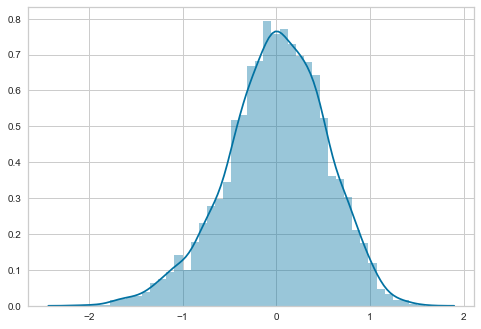

In [51]:
# Error residuals
residuals=train_y-linear_train_pred
sns.distplot(residuals)

In [52]:
# Decile analysis
train_new = pd.concat([train_y, linear_train_pred], axis=1)
train_new.columns = ['actual', 'pred']
test_new = pd.concat([test_y, linear_test_pred], axis=1)
test_new.columns = ['actual', 'pred']

In [53]:
# train decile
train_new['Deciles'] = pd.qcut(train_new.pred, 10, labels=False)

In [54]:
train_new.groupby('Deciles').mean()

,actual,pred
Deciles,,
0,5.384626,5.401619
1,5.626053,5.609735
2,5.719676,5.720024
3,5.823539,5.816227
4,5.923290,5.911140
5,6.003522,6.010379
6,6.106610,6.117675
7,6.252817,6.243622
8,6.399743,6.410575


In [55]:
# test decile
test_new['Deciles'] = pd.qcut(test_new.pred, 10, labels=False)

In [56]:
test_new.groupby('Deciles').mean()

,actual,pred
Deciles,,
0,5.479010,5.446680
1,5.739799,5.638072
2,5.784926,5.745459
3,5.821574,5.846684
4,5.949860,5.946812
5,6.103727,6.057495
6,6.200117,6.159215
7,6.248846,6.283697
8,6.402948,6.421537


# Using XGBoost

In [57]:
# X features list
ml_features=reg_data.columns.difference(['ln_totalspend'])

In [58]:
# Splitting the data into train and test
x_train,x_test,y_train,y_test=train_test_split(reg_data[ml_features],
                                               reg_data['ln_totalspend'],test_size=0.2,
                                               random_state=123)

In [58]:
xg_model=xgb.XGBRegressor()


In [66]:
# parameter grid
param_grid1={'n_estimators':np.arange(10,25),'max_depth':[3,4,5,6,7,8,9,10],'learning_rate':[0.01,0.05,0.10,0.15,0.20]}

In [67]:
# Grid search 
ml=GridSearchCV(xg_model,param_grid1,cv=5)

In [68]:
ml.fit(x_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=None,
             param_grid

In [69]:
# best params
ml.best_params_

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 24}

In [60]:
# Trainig dat with best params
ml_final=xgb.XGBRegressor(max_depth=3,learning_rate=0.2)
ml_final.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# Evaluation metrics

In [65]:
# Train and test predictions
xg_pred_test=ml_final.predict(x_test)
xg_pred_train=ml_final.predict(x_train)

In [66]:
# MSE
xg_MSE_test=metrics.mean_squared_error(y_test,xg_pred_test)
xg_MSE_train=metrics.mean_squared_error(y_train,xg_pred_train)
print('MSE Train:',xg_MSE_train)
print('MSE Test:',xg_MSE_test)


MSE Train: 0.22164751867936802
MSE Test: 0.27954361344642037


In [67]:
# RMSE
xg_RMSE_train=np.sqrt(metrics.mean_squared_error(y_train,xg_pred_train ))
xg_RMSE_test=np.sqrt(metrics.mean_squared_error(y_test, xg_pred_test))
print ('Train RMSE:',xg_RMSE_train )
print ('Test RMSE:',xg_RMSE_test )

Train RMSE: 0.4707945610129412
Test RMSE: 0.5287188415844667


In [68]:
# MAPE
MAPE_train = '%.3f' % np.mean(np.abs(y_train-xg_pred_train)/(y_train))
MAPE_test = '%.3f' % np.mean(np.abs(y_test-xg_pred_test)/(y_test))

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  0.064  |  MAPE of testing data:  0.071


In [64]:
# Importnt features 
ml_final.feature_importances_
list(zip(x_train.columns,ml_final.feature_importances_ ))

[('active_1', 0.007779817),
 ('age', 0.015868235),
 ('carbought_1', 0.017552817),
 ('card2_2', 0.04383871),
 ('card2_3', 0.0360846),
 ('card2_4', 0.026328072),
 ('card2benefit_4', 0.0021844034),
 ('card_2', 0.06127174),
 ('card_3', 0.052684806),
 ('card_4', 0.0845416),
 ('card_5', 0.02553709),
 ('cardmon', 0.012584687),
 ('carvalue', 0.016097318),
 ('commutetime', 0.01778109),
 ('commutewalk_1', 0.009081573),
 ('debtinc', 0.014581768),
 ('ed', 0.012460809),
 ('equipmon', 0.022780258),
 ('gender_1', 0.036253877),
 ('homeown_1', 0.01841115),
 ('hourstv', 0.01587117),
 ('jobsat_3', 0.010724713),
 ('lncreddebt', 0.017832767),
 ('lninc', 0.15175231),
 ('lnlongmon', 0.013269999),
 ('pets_cats', 0.018063383),
 ('pets_dogs', 0.011264311),
 ('pets_freshfish', 0.01392691),
 ('polparty_1', 0.015440819),
 ('reason_2', 0.071300454),
 ('region_3', 0.025957864),
 ('region_5', 0.010605962),
 ('reside', 0.012466405),
 ('spoused', 0.012746952),
 ('tenure', 0.0138877155),
 ('tollmon', 0.013481333),
 ('vo

# Using SVM Regressor

In [69]:

svr_model=SVR(kernel='linear')

In [70]:
svr_model.fit(x_train,y_train)

SVR(kernel='linear')

In [71]:
svr_train=svr_model.predict(x_train)
svr_test=svr_model.predict(x_test)

In [73]:
svr_MAPE_train = '%.3f' % np.mean(np.abs(y_train-svr_train)/(y_train))
svr_MAPE_test = '%.3f' % np.mean(np.abs(y_test-svr_test)/(y_test))

# print the values of MAPE for train and test
print('MAPE of training data: ', svr_MAPE_train,  ' | ', 'MAPE of testing data: ', svr_MAPE_test)

MAPE of training data:  0.075  |  MAPE of testing data:  0.072


In [74]:
# RMSE
svr_Rmse_train=np.sqrt(metrics.mean_squared_error(y_train,svr_train ))
svr_Rmse_test=np.sqrt(metrics.mean_squared_error(y_test,svr_test ))
print ('Train RMSE:', svr_Rmse_train)
print ('Test RMSE:', svr_Rmse_test)

Train RMSE: 0.5483588639195035
Test RMSE: 0.5366245136184916


In [75]:
# MSE
svr_MSE_test=metrics.mean_squared_error(y_test,svr_test)
svr_MSE_train=metrics.mean_squared_error(y_train,svr_train)
print('MSE Train:',svr_MSE_train)
print('MSE Test:',svr_MSE_test)

MSE Train: 0.3006974436390885
MSE Test: 0.2879658686162827


# Comparing models

In [82]:
Mse_train=[linear_MSE_Train,xg_MSE_train,svr_MSE_train]
Mse_test=[linear_MSE_Test,xg_MSE_test,svr_MSE_test]
Rmse_train=[linear_RMSE_Train,xg_RMSE_train,svr_Rmse_train]
Rmse_test=[linear_RMSE_Test,xg_RMSE_test,svr_Rmse_test]
Ma_train=[linear_MAPE_train,MAPE_train,svr_MAPE_train]
Ma_test=[linear_MAPE_test,MAPE_test,svr_MAPE_test]

In [93]:
Mse_train_vals=pd.Series(Mse_train,name='Mse_Train')
Mse_test_vals=pd.Series(Mse_test,name='Mse_Test')
Rmse_train_vals=pd.Series(Rmse_train,name='Rmse_Train')
Rmse_test_vals=pd.Series(Rmse_test,name='Rmse_Test')
Mape_train_vals=pd.Series(Ma_train,name='Mape_Train')
Mape_test_vals=pd.Series(Ma_test,name='Mape_Test')
names=pd.Series(['Linear_reg','Xgboost','SVR'],name='model')


# Comparing Train values

In [94]:
pd.concat([Mse_train_vals,Rmse_train_vals,Mape_train_vals,names],axis=1).set_index(['model'])

,Mse_Train,Rmse_Train,Mape_Train
model,,,
Linear_reg,0.281706,0.530760,0.073
Xgboost,0.221648,0.470795,0.064
SVR,0.300697,0.548359,0.075


# Comparing Test Values

In [95]:
pd.concat([Mse_test_vals,Rmse_test_vals,Mape_test_vals,names],axis=1).set_index(['model'])

,Mse_Test,Rmse_Test,Mape_Test
model,,,
Linear_reg,0.261918,0.511780,0.069
Xgboost,0.279544,0.528719,0.071
SVR,0.287966,0.536625,0.072


# We can see that the linear regression model has less overfitting and it has lower errors therefore it is the best model

# Important features